Test the three attributions of stream: Packets, Bytes, Flows. Specifically, flows here means the number of changing times between flows with payload from different direction. 

- $\frac{P}{F}$: 
- $\frac{B}{P}$: 
- $\frac{B}{F}$: 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import entropy

In [2]:
# stream information
data = pd.read_csv("./csv/statistics/unlabelled/ts_np_video1_bili_chrome_24-09-06--16-25-44.csv")

data_3tuple = data[['Stream ID', 'Packets', 'Bytes', 'Flows']].set_index('Stream ID')

In [7]:
# packets information
# packets = pd.read_csv("./csv/packets/np_video1_bili_chrome_24-09-06--16-25-44.csv")
packets = pd.read_csv("./csv/packets/1_np_video1_bili_chrome_24-09-06--16-25-44.csv") # with tcp segment column
packets = packets.dropna(subset=['TCP Stream index'])
# stream_number = 57
# stream_packets = packets[packets['TCP Stream index'] == stream_number]

In [8]:
# domain name manual
domain = pd.read_csv("./csv/domain/domain_np_video1_bili_chrome_24-09-06--16-25-44.csv")
domain_stream = {key: [] for key in domain['Domain Name']} # {'Domain Name': [Stream ID]}
# In packets, domain name is in the TLS handshake packets named 'Server Name'
packets_server_name = packets.dropna(subset=['Server Name']) # drop

packets_server_name_unique = packets['Server Name'].dropna().unique()
domain_stream_all = {key: [] for key in packets_server_name_unique}

In [5]:
for name in domain_stream.keys(): # retrieve the dictionary
    stream_ids = packets.loc[packets['Server Name'] == name, 'TCP Stream index']
    domain_stream[name].extend(stream_ids)

In [9]:
for name in domain_stream_all.keys(): 
    stream_ids = packets.loc[packets['Server Name'] == name, 'TCP Stream index']
    domain_stream_all[name].extend(stream_ids)

In [ ]:
for name, stream in domain_stream.items():
    for stream_id in stream:
        stream_packets = packets[packets['TCP Stream index'] == stream_id] # sentence in [] return bool series
        plt.figure(figsize=(5, 3))
        # plt.bar(stream_packets['Time'], stream_packets['Length'])
        plt.plot(stream_packets['Time'], stream_packets['Length'], marker='*')
        plt.title(f'{name}: Stream {stream_id}')
        plt.xlabel('Time')
        plt.ylabel('Length')
        plt.grid(True)
        plt.savefig(f'./test/imgs/{name}-Stream{stream_id}.png', dpi=300, bbox_inches='tight')
        plt.clf() # clear the cache

In [8]:
def flow_reversal_entropy(stream_no):
    """
    Calculate Bytes of each flow reversals, which can be definied into the effective information  
    """
    packets_stream = packets[packets['TCP Stream index'] == stream_no]

    if not packets_stream.empty:
        src_ip_temp = packets_stream.iloc[0]['Source']
        flow_no = 0
        flow_entropy_list = [0]  # init the first flow entropy
        flow_time_list = [0] # init the first flow time, duration of flow_reversal[0] = flow_time_list[1] - flow_time_list[0]
        initial_time = True

        for packet_no in range(packets_stream.shape[0]): 
            packet_current = packets_stream.iloc[packet_no]
            if packet_current['TCP Segment Len'] > 0: # if the packet has payload
                if src_ip_temp == packet_current['Source']:
                    if initial_time:
                        flow_time_list[flow_no] = packet_current['Time']
                        initial_time = False
                    flow_entropy_list[flow_no] += (packet_current['TCP Segment Len'])
                    # flow_time_list[flow_no][0] = packet_current['Time']
                else: # first time change the direction
                    flow_no += 1
                    flow_entropy_list.append(0)  # init new flow entropy
                    src_ip_temp = packet_current['Source']
                    flow_entropy_list[flow_no] += (packet_current['TCP Segment Len'])
                    flow_time_list.append(0)
                    flow_time_list[flow_no] = packet_current['Time']

    return flow_entropy_list, flow_time_list


In [9]:
for name, stream in domain_stream.items():
    for stream_id in stream:
        entropy_list, time_list = flow_reversal_entropy(stream_id)
        plt.plot(time_list, entropy_list, marker='*')
        plt.title(f'Stream{stream_id} Time-Entropy')
        plt.xlabel('Time')
        plt.ylabel('Entropy')
        plt.grid(True)
        plt.savefig(f'./test/entropy-time-imgs/{name}-Stream{stream_id}.png', dpi=300, bbox_inches='tight')
        # plt.show()
        plt.clf() # clear the cache

<Figure size 640x480 with 0 Axes>

In [11]:
stream_no = 3
packets_stream = packets[packets['TCP Stream index'] == stream_no]

if not packets_stream.empty:
    src_ip_temp = packets_stream.iloc[0]['Source']
    flow_no = 0
    flow_entropy_list = [0]  # init the first flow entropy
    flow_time_list = [0] # init the fist flow time, duration of flow_reversal[0] = flow_time_list[1] - flow_time_list[0]
    initial_time = True

    for packet_no in range(packets_stream.shape[0]): 
        packet_current = packets_stream.iloc[packet_no]
        if packet_current['TCP Segment Len'] > 0: # if the packet has payload
            if src_ip_temp == packet_current['Source']:
                if initial_time:
                    flow_time_list[flow_no] = packet_current['Time']
                    initial_time = False
                flow_entropy_list[flow_no] += (packet_current['TCP Segment Len'])
            else:
                flow_no += 1
                flow_entropy_list.append(0)  # init new flow entropy
                src_ip_temp = packet_current['Source']
                flow_entropy_list[flow_no] += (packet_current['TCP Segment Len'])
                flow_time_list.append(0)
                flow_time_list[flow_no] = packet_current['Time']

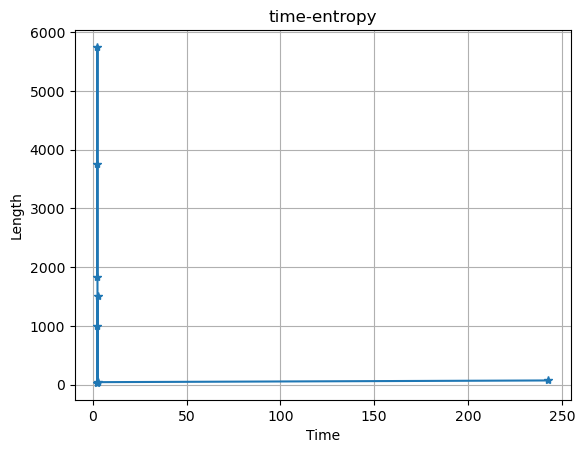

<Figure size 640x480 with 0 Axes>

In [12]:
plt.plot(flow_time_list, flow_entropy_list, marker='*')
plt.title("time-entropy")
plt.xlabel('Time')
plt.ylabel('Length')
plt.grid(True)
# plt.savefig(f'./test/imgs/{name}-Stream{stream_id}.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf() # clear the cache

In [ ]:
# test the distribution of two streams
# lognormal distribution can only work on 1-d data
# dist_stream1, dist_stream2 = 31, 40
# s1 = packets[packets['TCP Stream index'] == dist_stream1]
# s2 = packets[packets['TCP Stream index'] == dist_stream2]


In [3]:
data_3tuple['P/F'] = (data_3tuple['Packets'] / data_3tuple['Flows']).round(3)
data_3tuple['B/P'] = (data_3tuple['Bytes'] / data_3tuple['Packets']).round(3)
data_3tuple['B/F'] = (data_3tuple['Bytes'] / data_3tuple['Flows']).round(3)
# For inactive streams, it may have inf value

In [4]:
data_3tuple = data_3tuple.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

In [6]:
# data_3tuple.to_csv('./csv/statistics/test/data_3tuple.csv')